In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

# Local imports
from datasets import JunkFoodDataset
from qml.models.binary import BatchedGPUHybridQuantumCNN
from qml.ansatz.dense import DenseQCNNAnsatz4

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [3]:
# Configuration
train_data_folder = "data/data_aug"
test_data_folder = "data/data_noaug"

# Transform
IMAGE_SIZE = 128
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Load Datasets
train_dataset = JunkFoodDataset(train_data_folder, transform=transform)
full_test_dataset = JunkFoodDataset(test_data_folder, transform=transform)

# Determine size of test set to maintain ~80/20 ratio based on training size
# If Train is 80%, then Test should be 25% of Train size (since 20/80 = 1/4)
target_test_size = int(len(train_dataset) * 0.25)
print(f"Training count: {len(train_dataset)}")
print(f"Target Test count (for 80/20 ratio): {target_test_size}")

# Creates a random subset of the clean test data
indices = list(range(len(full_test_dataset)))
random.seed(42) # Ensure consistent test set
random.shuffle(indices)
test_dataset = Subset(full_test_dataset, indices[:target_test_size])

print(f"Actual Test count: {len(test_dataset)}")
print(f"Train/Test Ratio: {len(train_dataset)/(len(train_dataset)+len(test_dataset)):.2f}/{len(test_dataset)/(len(train_dataset)+len(test_dataset)):.2f}")

Training count: 4614
Target Test count (for 80/20 ratio): 1153
Actual Test count: 1153
Train/Test Ratio: 0.80/0.20


In [4]:
# Train/test configuration
BATCH_SIZE = 8
SEED = 42

# Create data loaders
torch.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training on {len(train_dataset)} augmented images, Testing on {len(test_dataset)} clean images.")

Training on 4614 augmented images, Testing on 1153 clean images.


## Create Quantum CNN Model

In [5]:
# Model configuration
model = BatchedGPUHybridQuantumCNN(
    kernel_size=3,
    stride=1,
    pool_size=24,
    encoding='dense',
    ansatz=DenseQCNNAnsatz4(),
    n_qubits=4,
    measurement='x',
    hidden_size=128
)

model = model.to(device)

Using lightning.qubit device with 'dense' encoding, DenseQCNNAnsatz4, measurement=PauliX
Using default.qubit device with 'dense' encoding, DenseQCNNAnsatz4, measurement=PauliX


## Setup Training

In [6]:
from notebooks.utils import print_model_parameters

# Display model parameter count
print_model_parameters(model)


MODEL PARAMETER COUNT
Total parameters:                74,015
Trainable parameters:            74,015
Non-trainable parameters:             0

Parameter breakdown by layer:
Layer                                    Parameters      Trainable 
-----------------------------------------------------------------
qconv.q_params                           30              Yes       
classical.1.weight                       73,728          Yes       
classical.1.bias                         128             Yes       
classical.4.weight                       128             Yes       
classical.4.bias                         1               Yes       


In [7]:
from notebooks.trainer import Trainer

# Training configuration
LEARNING_RATE = 0.003
EPOCHS = 15

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Create trainer
trainer = Trainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [8]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader
)

Evaluating: 100%|██████████| 145/145 [46:14<00:00, 19.13s/it]   


Epoch 1: Train Loss=0.6748, Train Acc=0.6346 | Test Loss=0.6062, Test Acc=0.6956


Evaluating: 100%|██████████| 145/145 [03:14<00:00,  1.34s/it]


Epoch 2: Train Loss=0.6153, Train Acc=0.6916 | Test Loss=0.5528, Test Acc=0.7147


Evaluating: 100%|██████████| 145/145 [03:03<00:00,  1.27s/it]


Epoch 3: Train Loss=0.5693, Train Acc=0.7133 | Test Loss=0.5366, Test Acc=0.7242


Evaluating: 100%|██████████| 145/145 [03:03<00:00,  1.26s/it]


Epoch 4: Train Loss=0.5318, Train Acc=0.7456 | Test Loss=0.4865, Test Acc=0.7580


Evaluating: 100%|██████████| 145/145 [03:02<00:00,  1.26s/it]


Epoch 5: Train Loss=0.5081, Train Acc=0.7616 | Test Loss=0.4595, Test Acc=0.7840


Evaluating: 100%|██████████| 145/145 [03:05<00:00,  1.28s/it]


Epoch 6: Train Loss=0.4765, Train Acc=0.7779 | Test Loss=0.4223, Test Acc=0.8153


Evaluating: 100%|██████████| 145/145 [03:04<00:00,  1.27s/it]


Epoch 7: Train Loss=0.4560, Train Acc=0.7917 | Test Loss=0.4399, Test Acc=0.8031


Evaluating: 100%|██████████| 145/145 [03:00<00:00,  1.24s/it]


Epoch 8: Train Loss=0.4324, Train Acc=0.8114 | Test Loss=0.3875, Test Acc=0.8474


Evaluating: 100%|██████████| 145/145 [03:01<00:00,  1.25s/it]


Epoch 9: Train Loss=0.4186, Train Acc=0.8249 | Test Loss=0.3881, Test Acc=0.8352


Evaluating: 100%|██████████| 145/145 [03:04<00:00,  1.27s/it]


Epoch 10: Train Loss=0.3885, Train Acc=0.8429 | Test Loss=0.5436, Test Acc=0.8283


Evaluating: 100%|██████████| 145/145 [03:02<00:00,  1.26s/it]


Epoch 11: Train Loss=0.3642, Train Acc=0.8476 | Test Loss=0.3574, Test Acc=0.8638


Evaluating: 100%|██████████| 145/145 [03:07<00:00,  1.29s/it]


Epoch 12: Train Loss=0.3545, Train Acc=0.8559 | Test Loss=0.3641, Test Acc=0.8699


Evaluating: 100%|██████████| 145/145 [03:02<00:00,  1.26s/it]


Epoch 13: Train Loss=0.3490, Train Acc=0.8671 | Test Loss=0.3202, Test Acc=0.8768


Evaluating: 100%|██████████| 145/145 [02:59<00:00,  1.24s/it]


Epoch 14: Train Loss=0.3459, Train Acc=0.8693 | Test Loss=0.3218, Test Acc=0.8855


Evaluating: 100%|██████████| 145/145 [03:04<00:00,  1.27s/it]

Epoch 15: Train Loss=0.3082, Train Acc=0.8758 | Test Loss=0.4121, Test Acc=0.8300


## Train results

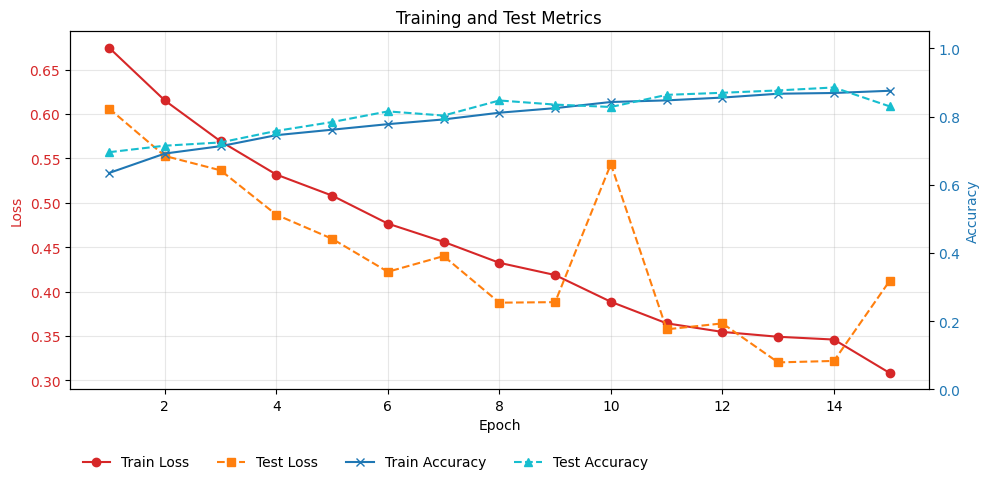

In [9]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 145/145 [03:02<00:00,  1.26s/it]


Final Test Results:
Test Loss: 0.4121
Test Accuracy: 0.8300


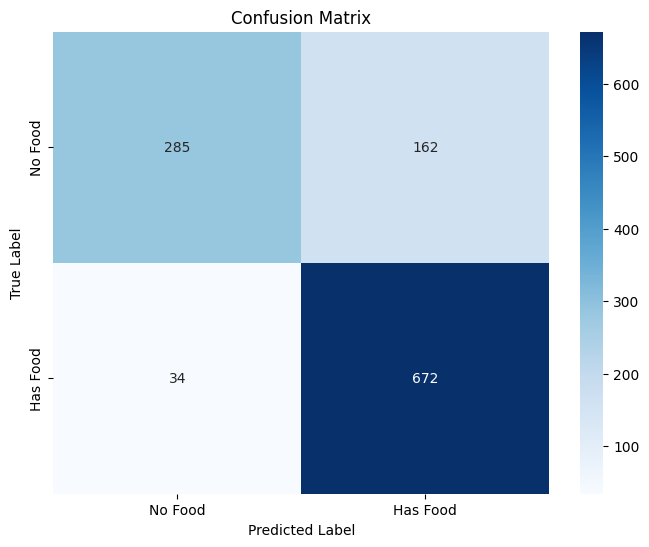


Detailed Metrics:
Precision: 0.8058
Recall: 0.9518
F1 Score: 0.8727

Confusion Matrix:
True Negatives:  285
False Positives: 162
False Negatives: 34
True Positives:  672


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Food', 'Has Food'], 
            yticklabels=['No Food', 'Has Food'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Print detailed metrics
tn, fp, fn, tp = confusion_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")